# 1. 로지스틱 회귀로 와인 분류

## 1-1. 데이터 준비
1. 데이터 불러오기
2. 데이터 missing values, statistics 확인하기

In [1]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine-date')
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [3]:
wine.info() # missing values 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [4]:
wine.describe() # statistics 확인

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [7]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy() # 사용할 열(features) 분류해서 새로운 데이터프레임 반환하기
target = wine['class'].to_numpy() # target 분류하기 [괄호]는 하나만!!

In [10]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size = 0.2, random_state = 42)
print(train_data.shape, test_data.shape)

(5197, 3) (1300, 3)


## 1-2. 데이터 표준화 처리
- 데이터 전처리를 하는 이유: `wine.describe()`를 통해 수치 데이터가 가진 통계값을 보니 각각의 feature data들의 스케일이 다르다는 것을 확인.
- 스케일을 비슷한 범위로 맞춰주는 과정이 학습 모델의 정확도 개선을 위해 꼭 필요하다. 

In [11]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(train_data)
train_scaled = scale.transform(train_data)
test_scaled = scale.transform(test_data)

## 1-3. 로지스틱 회귀 모델 훈련하기 

In [12]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target)) # 정확도 낮음. underfitting

0.7808350971714451
0.7776923076923077


In [13]:
print(lr.coef_, lr.intercept_)

[[ 0.51270274  1.6733911  -0.68767781]] [1.81777902]


대부분의 머신러닝 모델은 결과를 설명하기에 어렵다. coef_의 값과 Intercept_의 값에 대해 왜 이런 계수 값을 학습했는지도 우리는 추측만 할 뿐, 정확하게 이해하기 어렵기 때문이다. 여기에 다항의 특성까지 더해진다면 더 설명하기 어려운 모델이 될 것이다. 이런 점에서 **결정트리(Decision Tree)** 모델은 학습의 결과를 설명하기 쉽다는 장점이 있다.

# 2. Decision tree (결정 트리)

## 2-1. 모델 학습

In [28]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target)) # 로지스틱 회귀 모델에 비교하면 정확도 높음. 테스트 세트 성능 낮음. overfitting

0.996921300750433
0.8538461538461538


In [20]:
dt.classes_ # 음성 클래스 0, 양성 클래스 1 

array([0., 1.])

## 2-2. 훈련한 모델 시각화
- 트리 이해하기

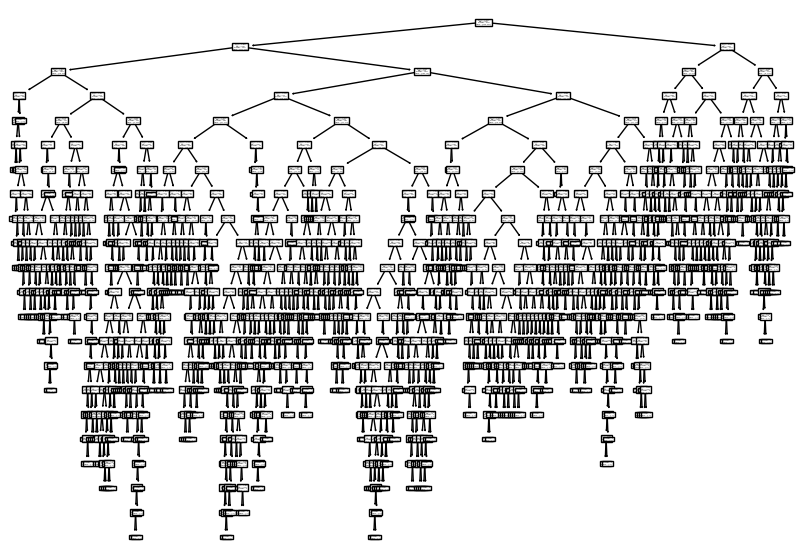

In [18]:
import matplotlib.pyplot as plt # 모델을 시각화해서 볼 것이다.
from sklearn.tree import plot_tree # 결정 트리 그래프 그리러 plot_tree 호출
plt.figure(figsize = (10, 7))
plot_tree(dt) # 결정 트리 그래프 그리기
plt.show()

- **결정 트리에 너무 많은 가지가 존재하는 걸 볼 수 있다. 이런 부분이 'overfitting의 요인'이 될 수 있다.**
- **트리 이해를 돕기 위해 트리의 깊이를 제한해서 출력할 것이다.** `max_depth = n`

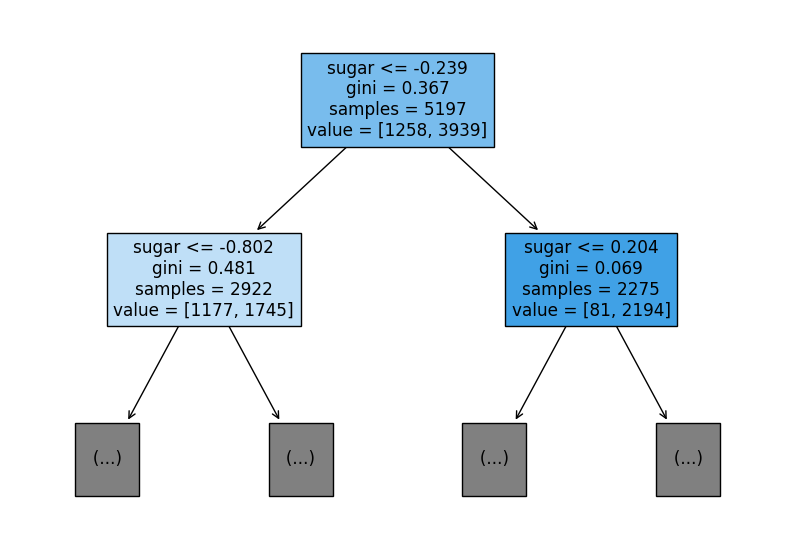

In [19]:
plt.figure(figsize = (10, 7))
plot_tree(dt, max_depth = 1, filled = True, feature_names = ['alcohol', 'sugar', 'pH'])
            # max_depth 트리 깊이 제한 정의
                            # filled 색상 표시: 클래스 마다 색상 부여, 특정 클래스의 비율이 높아지면 점점 진한 색으로 표시
plt.show()

**트리 구성**
1. 루트 노드 (제일 꼭대기 노드)
2. 가지
3. 리프 노드 (분류된 노드)

**노드 구성**
1. 테스트 조건
2. 불순도
3. 총 샘플 수
4. 클래스별 샘플 수

## 2-3. 불순도 (Gini Impurity)
- DecisionTreeClassifier() 클래스의 criterion 매개변수 기본 값 = **gini**
- criterion 매개변수: 노드에서 데이터 분할할 기준을 정하는 것
- $불순도 = 1 - (음성 클래스 비율^2 + 양성 클래스 비율^2)$

- 불순도는 클래스별 비율을 가지고 계산된 값이다. 따라서 샘플을 어떤 클래스 비율로 나누는지 계산할 때 특징 값의 스케일이 계산에 영향을 미치지 않는다.
    - 표준화 전처리를 할 필요가 없다는 장점!

## 2-4. 가지치기 (Pruning)
- `max_depth` 매개변수를 조정해 overfitting을 해결할 수 있다.

In [30]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target)) # max_depth 지정하기 전보다 훈련 세트 정확도가 떨어졌지만 overfitting을 해결했다.

0.8454877814123533
0.8415384615384616


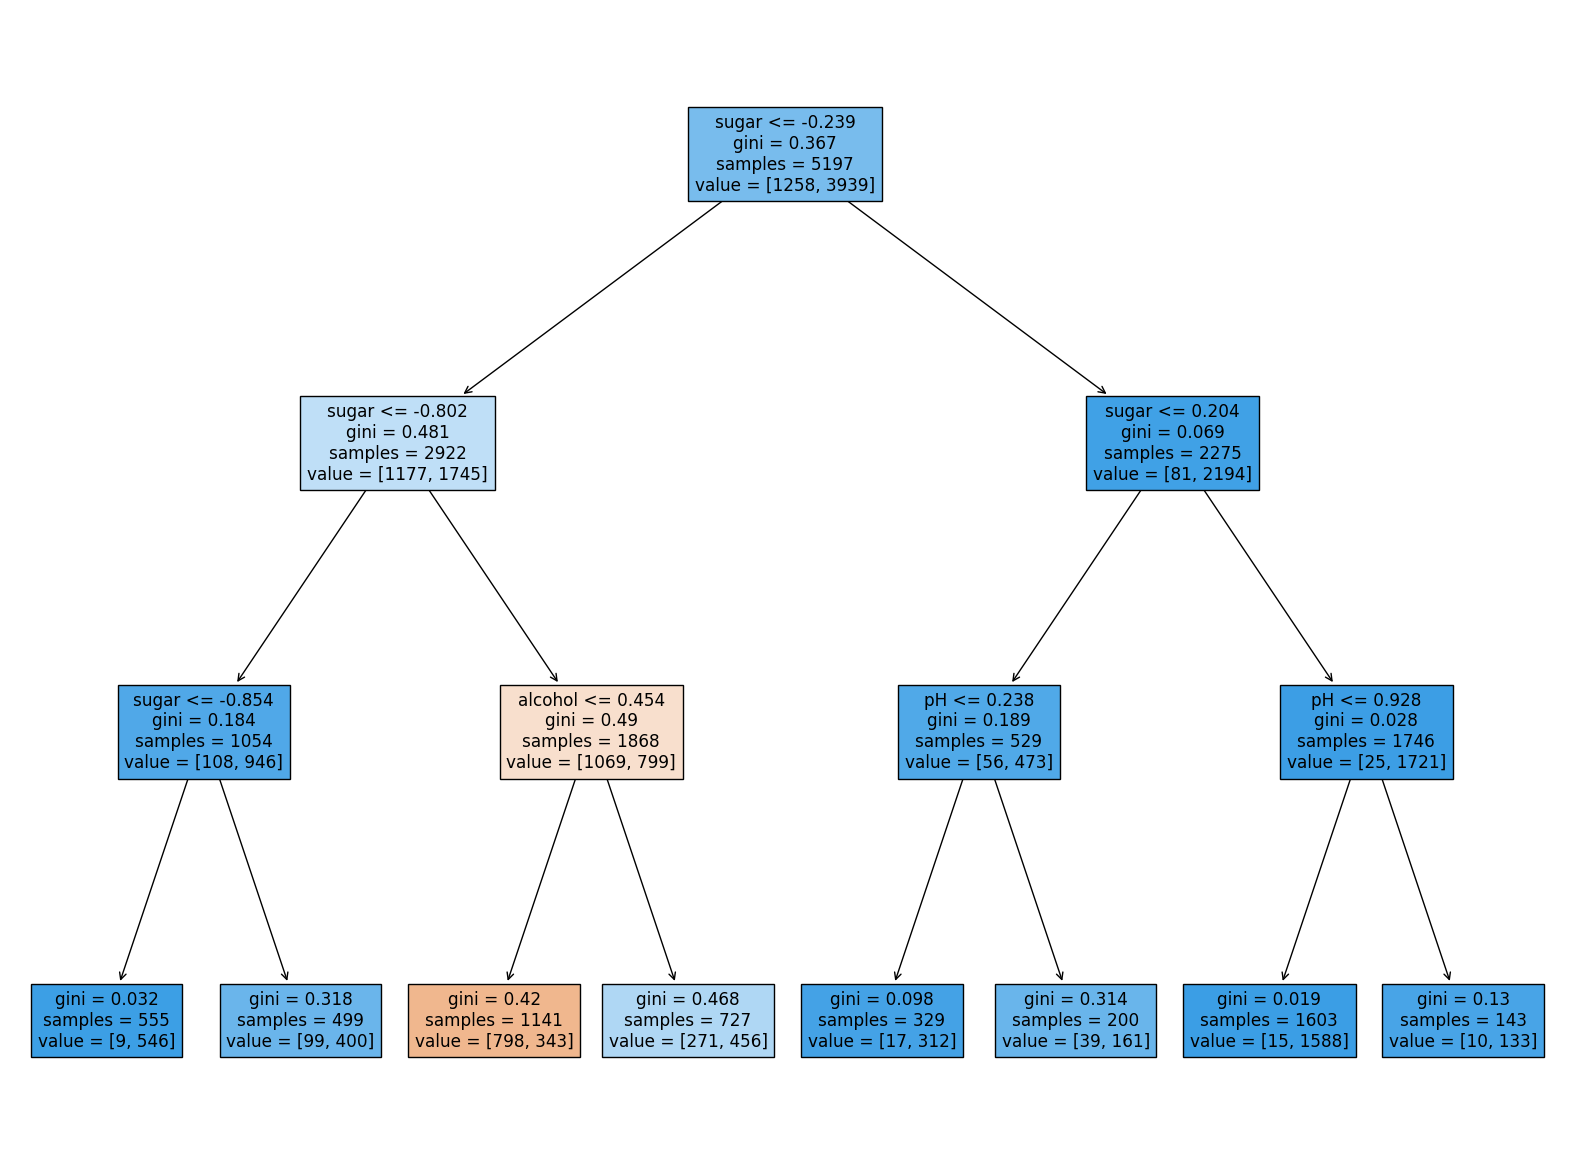

In [31]:
plt.figure(figsize = (20, 15))
plot_tree(dt, filled = True, feature_names = ['alcohol', 'sugar', 'pH'])
plt.show()

## 2-5. 결정 트리 모델 재학습
- 결정 트리 알고리즘은 표준화 전처리가 필요없지만 우리는 지금 표준화 전처리를 한 값으로 모델 학습을 했다.
- 전처리하기 전 데이터로 다시 학습해보면 특성값으로 확인할 수 있고, `filled` 매개변수로 인해 직관적인 이해가 가능하다.

In [32]:
dt.fit(train_data, train_target)
print(dt.score(train_data, train_target))
print(dt.score(test_data, test_target))

0.8454877814123533
0.8415384615384616


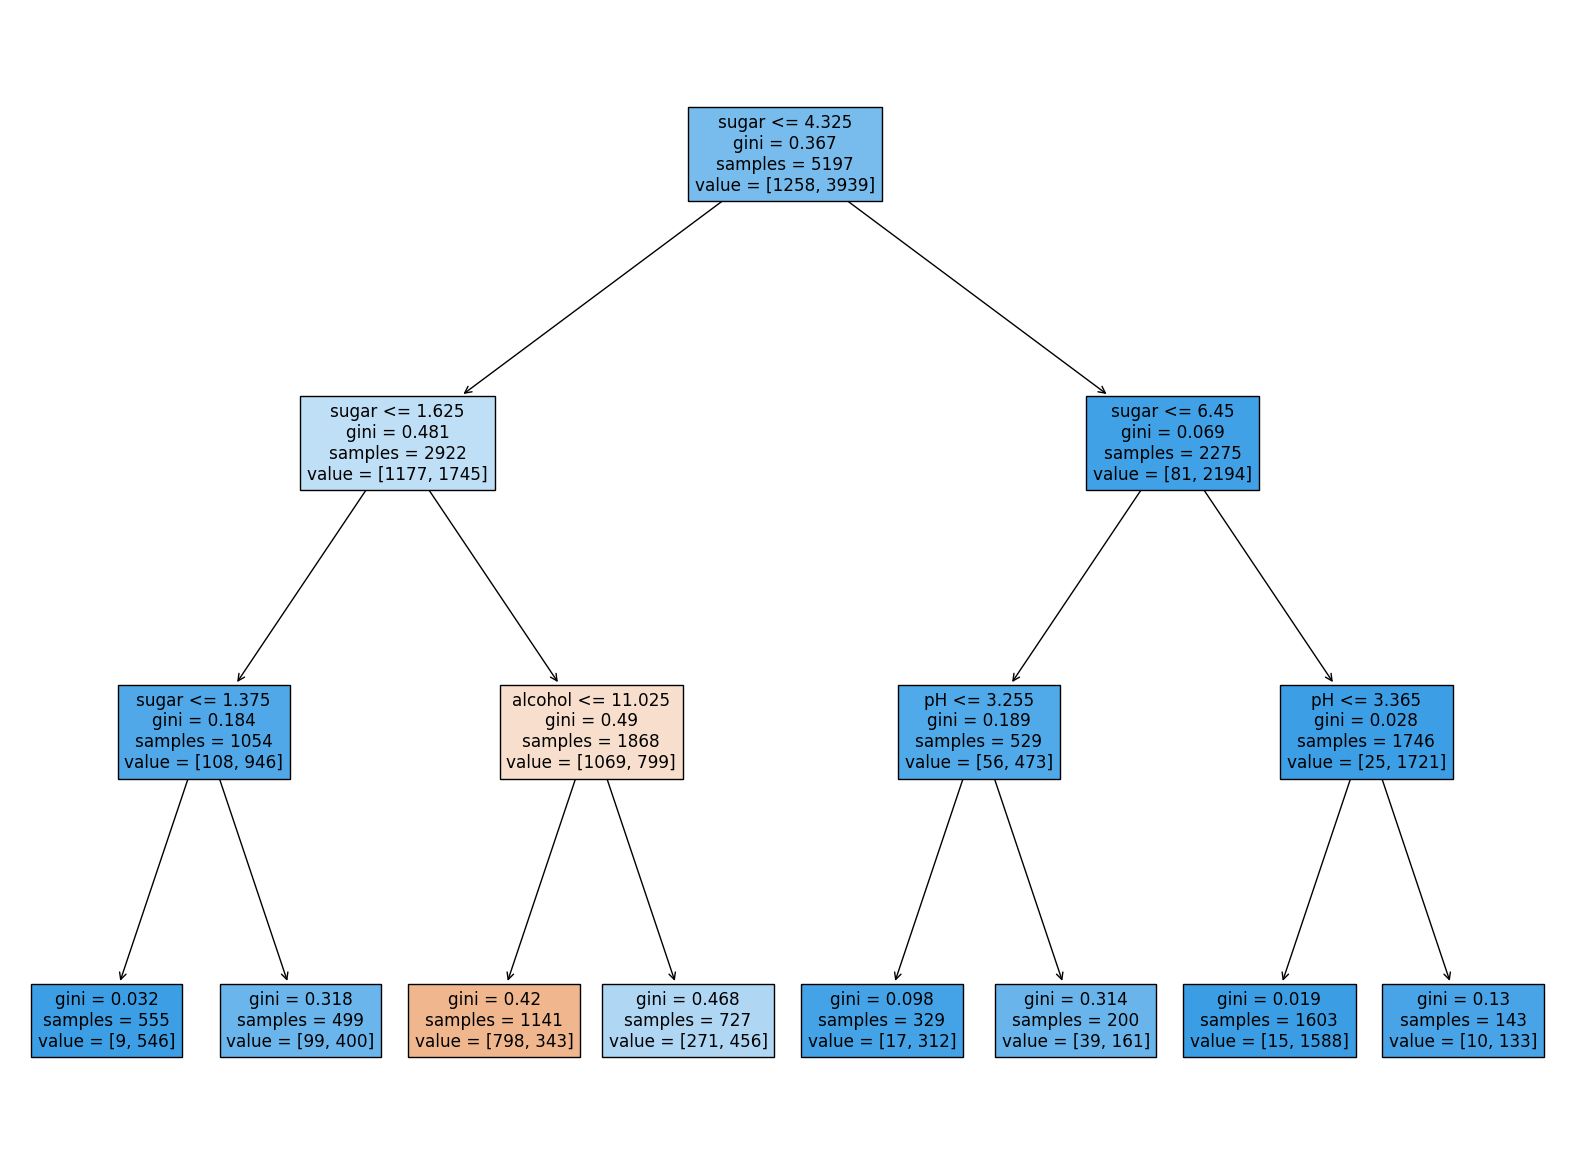

In [33]:
plt.figure(figsize = (20, 15))
plot_tree(dt, filled = True, feature_names = ['alcohol', 'sugar', 'pH'])
plt.show()

## 2-6. Overfitting 해결하는 다른 방법
- `min_impurity_decrease` 매개변수를 조정해 overfitting을 해결할 수 있다.

In [35]:
dt = DecisionTreeClassifier(min_impurity_decrease=0.0005, random_state=42)
dt.fit(train_data, train_target)

print(dt.score(train_data, train_target))
print(dt.score(test_data, test_target))

0.8874350586877044
0.8615384615384616


- **정확도 점수가 조금 더 높아지긴 했지만 overfitting이 완전히 해결되지는 않았다.**
- **결정 트리를 시각화해보면 최소 불순도만 조절하다 보니 가지의 깊이가 깊어졌기 때문이라는 것을 알 수 있다.**

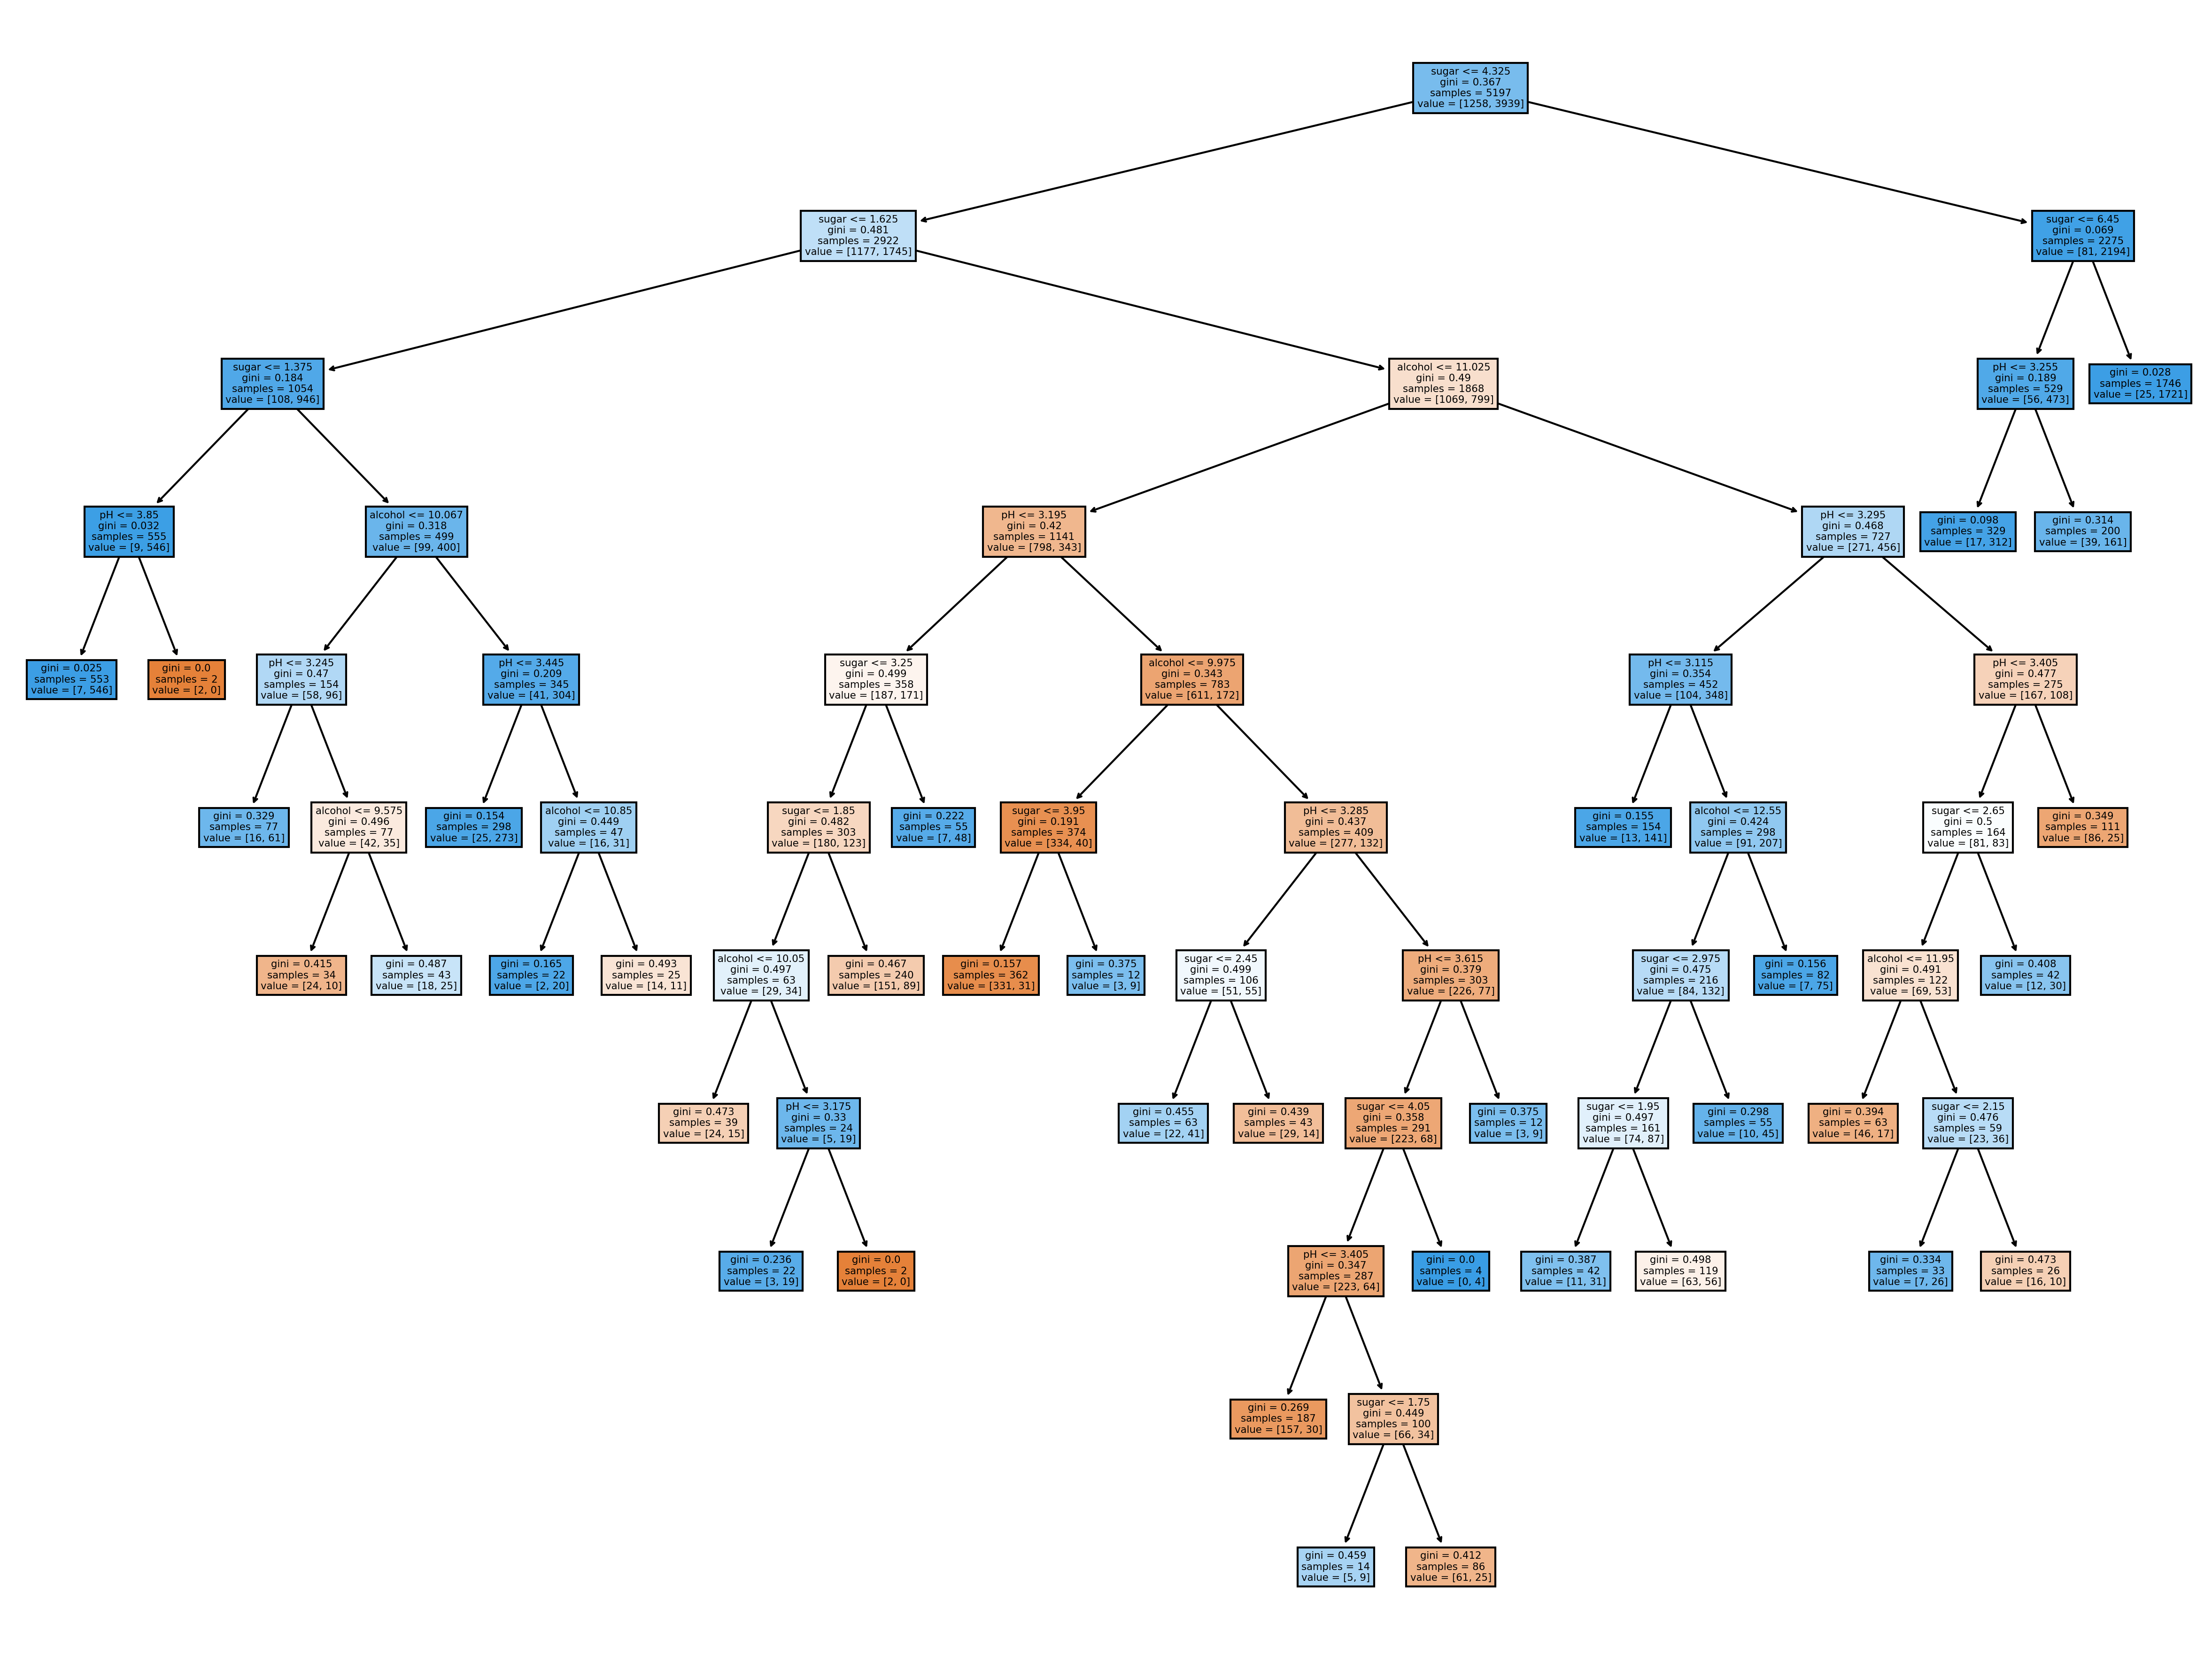

In [36]:
plt.figure(figsize=(20,15), dpi=300)
                            # dpi = 그래프 해상도
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

## 2-7. 특성 중요도 (Feature Importance)

In [34]:
print(dt.feature_importances_) # 두번째에 위치한 특성, 즉 '당도'가 가장 중요한 특징이다.

[0.12345626 0.86862934 0.0079144 ]


# 정리
1. 결정 트리는 이해하기 쉽고 설명하기 쉽다.
2. 표준화 전처리를 하지 않아도 된다.
3. 특징 중요도를 계산해준다.
4. 매개변수 (Hyper Parameter)를 설정해서 overfitting을 해결할 수 있는데, 직접 값을 설정해도 되고 자동으로 적절한 값을 골라주는 AutoML 클래스 (GridSearchCV)가 있다.